# Piecewise Exact Method

### Implementation

In this lecture, we'll develop a simple algorithm to implement the piecewise exact method.

In [1]:
# DEPENDENCIES
import math
import numpy as np
import matplotlib.pyplot as plt

# SYSTEM CONSTANTS
m = 1000 #(kg) Mass
k = 20000 #(N/m) Stiffness
xi = 0.05 # Damping ratio 
P = 750 # (N) Force magnitude
f = 1 # (Hz) Forcing frequency
pi = math.pi #Define pi for convenience 

# DYNAMIC PARAMETERS
omega_n = math.sqrt(k/m) #(rads/sec) Undamped natural frequency
f_n = omega_n/(2*pi) #(Hz) Undamped natural frequency
omega_d = omega_n*math.sqrt(1-xi**2) #Damped natural frequency
omega = 2*pi*f #(rads/sec) Forcing frequency
beta = omega/omega_n # Frequency ratio
tmax = 30 #(sec) The max time
delta_t = 0.01 #(sec) The timestep

# DEFINE AN 'EXPERIMENTAL' FORCE VECTOR
nPoints = tmax/delta_t #Number of equally spaced data points
t = np.linspace(0,tmax, int(nPoints)) # Time vector
F_sine = P*np.sin(omega*t) #Force vector

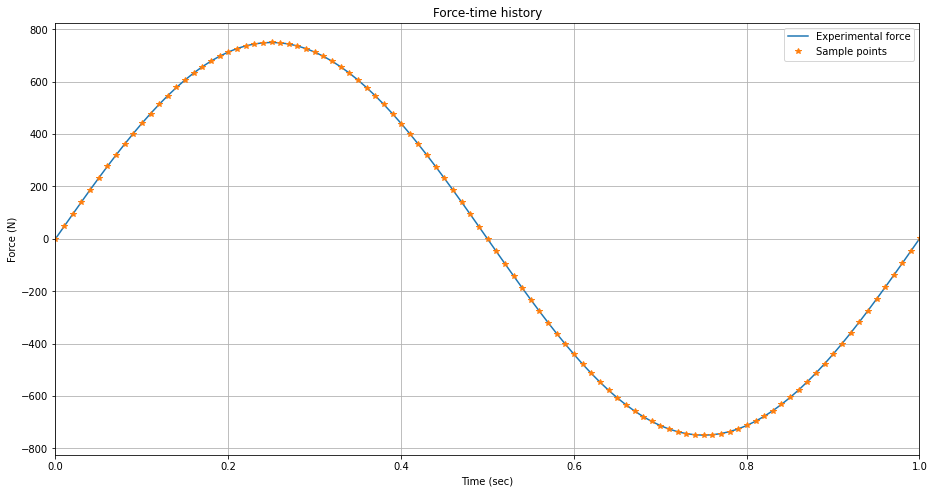

In [2]:
#Plot the 'experimental' force and sampling points
fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,2,1.5]) 
axes.plot(t,F_sine,label='Experimental force')
axes.plot(t,F_sine,'*',label='Sample points')
axes.set_xlim([0,1])
axes.set_xlabel('Time (sec)')
axes.set_ylabel('Force (N)')
axes.set_title('Force-time history')
axes.grid()
axes.legend()
plt.show()

Our task is to develop an algorithm to calculate the response of our system to the sampled force data (orange stars)

### Define a function to calculate dynamic response

In [3]:
#Define a function that takes in a time and force vector
def calculateResponse(tVector, fVector):
    '''
    NOTE: All our system parameters are defined globally and not explicitly passed 
    into our function as arguments. This limits our flexibility when calling the function,
    a better approach might be to pass in all relevent dynamic parameters so they could 
    be specified when the function was called. Try modifying the function to achieve this. 
    '''
        
    nPoints = len(tVector) #Number of data points 
    
    #Constants
    A = math.e**(-xi*omega_n*delta_t)*((xi/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t)+np.cos(omega_d*delta_t))
    B = math.e**(-xi*omega_n*delta_t)*((1/omega_d*np.sin(omega_d*delta_t)))
    C = (1/k)*(((2*xi)/(omega_n*delta_t)) + math.e**(-xi*omega_n*delta_t)*((((1-2*(xi**2))/(omega_d*delta_t))-(xi/(math.sqrt(1-(xi**2)))))*math.sin(omega_d*delta_t)-(1+((2*xi)/(omega_n*delta_t)))*np.cos(omega_d*delta_t)))
    D = (1/k)*(1-((2*xi)/(omega_n*delta_t))+math.e**(-xi*omega_n*delta_t)*(((2*(xi**2)-1)/(omega_d*delta_t))*np.sin(omega_d*delta_t)+((2*xi)/(omega_n*delta_t))*np.cos(omega_d*delta_t)))

    A1 = -math.e**(-xi*omega_n*delta_t)*((omega_n/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t))
    B1 = math.e**(-xi*omega_n*delta_t)*(np.cos(omega_d*delta_t)-((xi)/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t))
    C1 =(1/k)*(-(1/delta_t)+math.e**(-xi*omega_n*delta_t)*((((omega_n)/(math.sqrt(1-(xi**2))))+((xi)/(delta_t*math.sqrt(1-(xi**2)))))*np.sin(omega_d*delta_t)+(1/delta_t)*np.cos(omega_d*delta_t)))
    D1 =(1/k)*((1/delta_t)-(math.e**(-xi*omega_n*delta_t)/delta_t)*((xi/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t)+np.cos(omega_d*delta_t))) 

    #INITIAL CONDITIONS
    x0=0 
    v0=0

    pos = [] #Initialise an array to hold calculated position
    vel = [] #Initialise an array to hold calculated velocity
    
    #MAIN LOOP (to 'step through' solution)
    for n, timestep in enumerate(tVector):
        #note that enumerate adds a counter to an iterable (n)
        timestep = round(timestep,3) #The current time

        #Update the force values
        if n<nPoints-1:
            Fn = fVector[n]
            Fnp1 = fVector[n+1]
        else:
            #Pickup when we're at the end of the force vector (no more +1 values)
            Fn = fVector[n]
            Fnp1 = 0
            
        #Calculate the position and velocity at the end of the timestep
        curPos = (A*x0) + (B*v0) + (C*Fn) + (D*Fnp1)
        curVel = (A1*x0) + (B1*v0)+ (C1*Fn) + (D1*Fnp1)

        #Append (save) the position and velocity into the vectors defined above
        pos.append(curPos)
        vel.append(curVel)

        #Update initial conditions for the next loop iteration     
        x0 = curPos;
        v0 = curVel;
    
    return pos #Return the calculated position out of the function      

Now call the function and pass it our time and force data

In [4]:
position = calculateResponse(t, F_sine) #Calling our function

Plot the system response

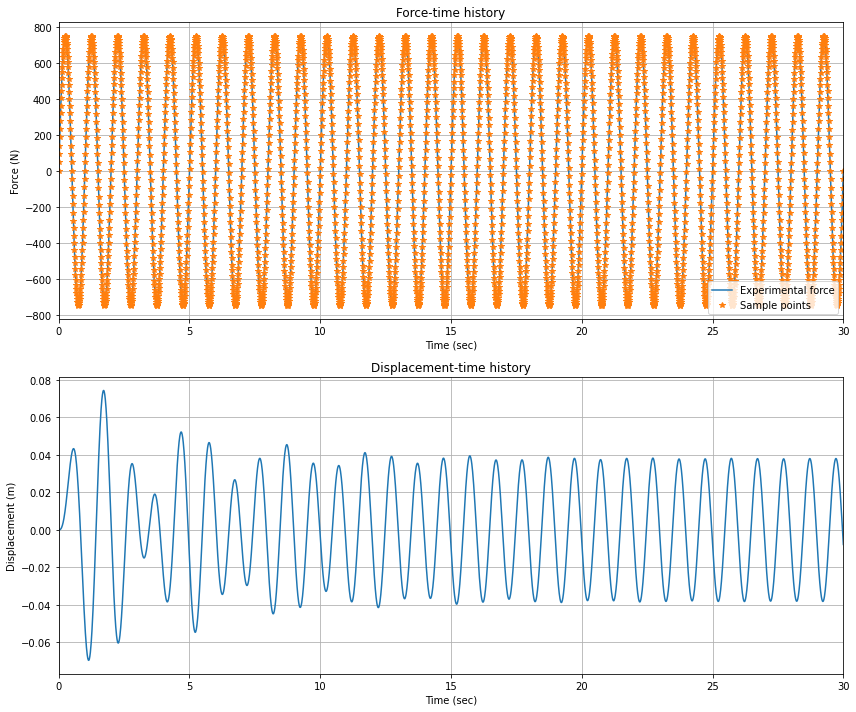

In [5]:
#Plot the force 
fig, axes = plt.subplots(figsize=(12,10),nrows=2,ncols=1) 
axes[0].plot(t,F_sine,label='Experimental force')
axes[0].plot(t,F_sine,'*',label='Sample points')
axes[0].set_xlabel('Time (sec)')
axes[0].set_ylabel('Force (N)')
axes[0].set_title('Force-time history')
axes[0].legend(loc='lower right')
axes[0].set_xlim([0,tmax])
axes[0].grid()


#Plot the response
axes[1].plot(t,position,'-')
axes[1].set_xlabel('Time (sec)')
axes[1].set_ylabel('Displacement (m)')
axes[1].set_title('Displacement-time history')
axes[1].set_xlim([0,tmax])
axes[1].grid()

plt.tight_layout()

### Remember...

<ul>
<li> This approach will work for **any** force vector - we just happen to define a sinusoid here because it was convenient for demonstration purposes.  
<li> This **numerical solution** is well suited to evaluating the impact of experimentally observed forces (represented as a list of sampled force values).    
<li> This method is also well suited to modelling dynamic behaviour of structures that exhibit nonlinear behaviour because we can alter our algorithm to change dynamic properties between iterations.
<li> We can also alter the applied force between iterations even making it dependent on the structural response in the previous iteration - modelling feedback between force and response. 
</ul>

For completeness, let's compare our numerical solution to the closed-form solution for harmonic excitation,

\begin{equation}
u(t) = e^{-\xi\omega_nt}[A\sin(\omega_dt) + B\cos(\omega_dt)] + \frac{P_0}{k}\left[\frac{1}{(1-\beta^2)^2+(2\xi\beta)^2}\right][(1-\beta^2)\sin(\omega t) - 2\xi\beta\cos(\omega t)]
\end{equation}

Following the same procedure we worked through in Worked Example #3:

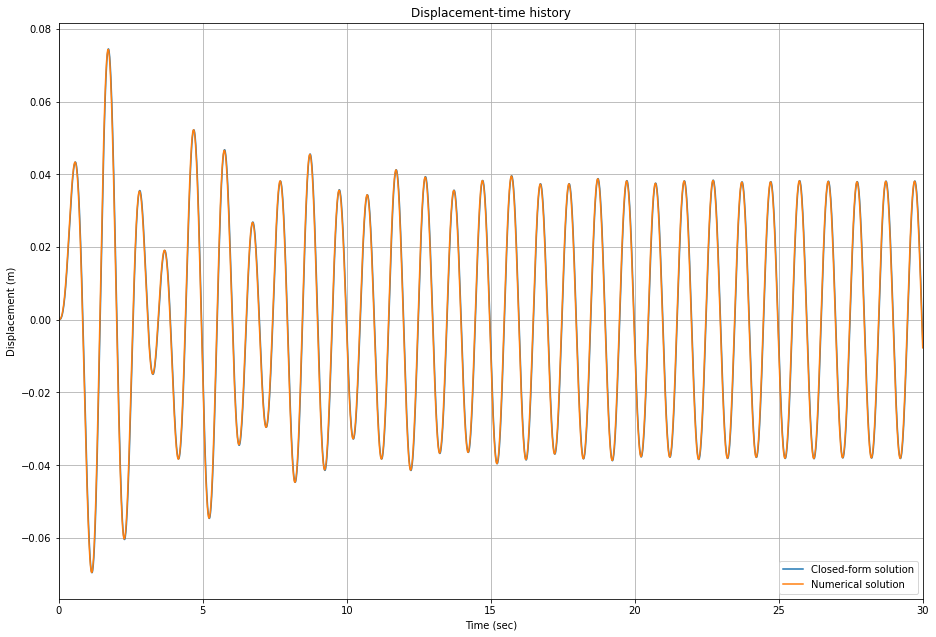

In [6]:
#Constants for calculation of closed-form solution (refer to Worked Example #3)
O = (P/k)*(1/((1-beta**2)**2 + (2*xi*beta)**2)) #Capital Omega defined above
C1 = O*(1-beta**2) #Defined above
C2 = -O*2*xi*beta #Defined above
omega_d = omega_n*math.sqrt(1-xi**2) #Damped natural frequency
A = (-1/omega_d)*(C2*xi*omega_n + C1*omega) #Constant of integration
B = -C2 #Constant of integration

ut = math.e**(-xi*omega_n*t)*(A*np.sin(omega_d*t) + B*np.cos(omega_d*t)) #Transient response
us = O*((1-beta**2)*np.sin(omega*t) - 2*xi*beta*np.cos(omega*t)) #Steady-state response

fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,2,2]) 
axes.plot(t,(ut+us), label='Closed-form solution')
axes.plot(t,position, label= 'Numerical solution')
axes.set_xlim([0,tmax])
axes.set_xlabel('Time (sec)')
axes.set_ylabel('Displacement (m)')
axes.set_title('Displacement-time history')
axes.grid()
axes.legend(loc='lower right')
plt.show()